# Accessing Planette's C3S Seasonal Forecast Data on AWS

This tutorial demonstrates how to access and analyze the C3S seasonal forecast data stored in Zarr format on AWS S3 using Python tools such as `xarray`, `zarr`, and `s3fs`. The data is chunked with [icechunk](https://github.com/rsignell/icechunk) for efficient cloud-native access.


<img src="planette_icon.png" width=5000px height=150px />


## Prerequisites

Install the required packages if you haven't already:

```bash
pip install xarray zarr icechunk matplotlib
```

## 1. Import Libraries


In [1]:
import xarray as xr
import icechunk as ic


## 2. Define Zarr store path

The data is publicly accessible, so you do not need AWS credentials.


In [4]:
# get the bucket and prefix
year = 2025 # Forecasts are stored by year, and available from 1981 to present
variable = "t2m" # 2 meter temperature (K)
bucket = "planette-c3s-seasonal-forecasts"
prefix = f"seas5/sys51/{variable}/day/1latx1lon/seas5_sys51_{variable}_day_1latx1lon_{year}.zarr"


## 3. Get icechunk session and repo

Data is stored in Zarr format and is written with icechunk. To open data, you must use icechunk session and repo.


In [5]:
# get storage and repo for icechunk
storage = ic.s3_storage(bucket=bucket, prefix=prefix, from_env=True)
repo = ic.Repository.open(storage=storage)

# return readonly session
session = repo.readonly_session("main")


## 4. Open the Dataset with Xarray

### Here are a few details about the data
##### 1.) there is one zarr store/variable for each year in the C3S record
##### 2.) Initalization times are for the first of every month (see 'init_time' dimension)
##### 3.) 'number' dimension corresponds to the ensemble member number. For seas5, there are 25 members in the hindcasts and 51 memebers in the forecasts
##### 4.) 'lead' dimension is the leadtime for the forecast
##### 5.) 'valid_time' coordinate tells you the time the forecast is valid for. If its you are looking at a 01/01 (january 1st) initialization, and you have a lead of 1 days, then the valid time is 01/02 (january 2nd). 
##### 6.) data is chunked by ensemble member and lead time where lead times of 14 days are included in one chunk


In [6]:
ds = xr.open_dataset(session.store, engine="zarr", consolidated=False, decode_timedelta=True, chunks={})
ds

<xarray.Dataset> Size: 28GB
Dimensions:     (lead: 215, number: 51, lat: 180, init_time: 10, lon: 360)
Coordinates:
  * lead        (lead) timedelta64[ns] 2kB 1 days 2 days ... 214 days 215 days
  * number      (number) int64 408B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49 50
  * lat         (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
    surface     float64 8B ...
    valid_time  (init_time, lead) datetime64[ns] 17kB dask.array<chunksize=(1, 14), meta=np.ndarray>
  * lon         (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * init_time   (init_time) datetime64[ns] 80B 2025-01-01 ... 2025-10-01
    year        int64 8B ...
Data variables:
    t2m         (init_time, number, lead, lat, lon) float32 28GB dask.array<chunksize=(1, 51, 14, 180, 360), meta=np.ndarray>

## 5. Explore the Data


In [7]:
t2m_jan_init = ds.isel(init_time=0, lead=0, number=0)

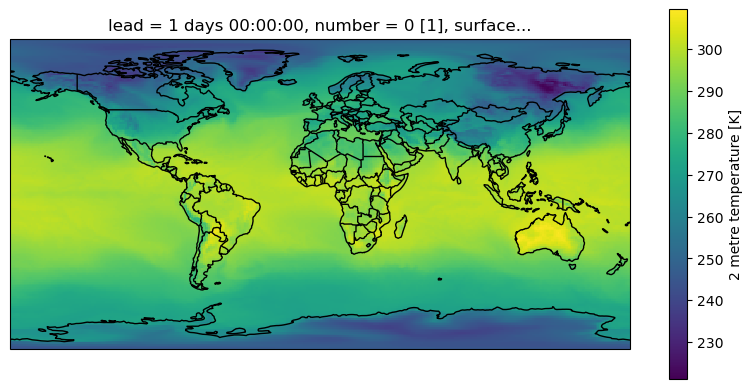

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
t2m_jan_init['t2m'].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8})

plt.show()